 *importing essential Python libraries/modules such as 'os', 'librosa', 'math', 'json', 'matplotlib.pyplot' (aliased as 'plt'), and 'numpy' (aliased as 'np') for functionalities related to operating system interaction, audio processing, mathematical operations, JSON handling, visualization, and scientific computing.*

In [4]:
import os
import librosa
import math
import json 
import matplotlib.pyplot as plt
import numpy as np

*initializing variables related to audio processing, setting paths for dataset and JSON file, specifying sample rate, track duration, and calculating the total number of samples per audio track based on the defined duration and sample rate:*

In [5]:
dataset_path = r"c:\\Users\\ayoba\\OneDrive - Ashesi University\\Year 2 sem 2 fall\\AI\\FINAL PROJECT\\Data\\genres_original"
json_path = r"data.json"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

*defining a function named save_mfcc that processes audio files from a specified dataset directory, extracts MFCC (Mel-frequency cepstral coefficients) features from segments of those audio files, and saves the extracted data including MFCCs, corresponding labels, and semantic labels into a JSON file:*

In [6]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(SAMPLES_PER_TRACK / num_segments) # ps = per segment
    expected_vects_ps = math.ceil(samples_ps / hop_length)
    
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath != dataset_path:
            dirpath_comp = dirpath.split("\\")  # Corrected path separator
            semantic_label = dirpath_comp[-1]
            data["mapping"].append(semantic_label)
            print(f"Processing: {semantic_label}")
            
            for f in filenames:
                # since this file is more than 1mb and cant be read by the librosa library
                if f == str("jazz.00054.wav"):
                    continue
                else:
                    file_path = os.path.join(dirpath, f)
                    try:
                        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                    except Exception as e:
                        print(f"Error encountered while loading {file_path}: {e}")
                        continue
                    
                    for s in range(num_segments):
                        start_sample = samples_ps * s
                        finish_sample = start_sample + samples_ps

                        mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                                    sr=sr,
                                                    n_fft=n_fft,
                                                    n_mfcc=n_mfcc,
                                                    hop_length=hop_length)

                        mfcc = mfcc.T

                        if len(mfcc) == expected_vects_ps:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i)  # Adjusted label appending

                            print(f"{file_path}, segment: {s+1}")

    with open(json_path, "w") as f:
        json.dump(data, f, indent=4)

In [7]:
from IPython.display import clear_output

In [8]:
save_mfcc(dataset_path,json_path,num_segments=10)
clear_output()

*importing necessary libraries from scikit-learn (json, train_test_split, StandardScaler, SVC, accuracy_score, classification_report) used for data handling, preprocessing, support vector machine (SVM) classification, and performance evaluation in machine learning tasks:*

In [9]:
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

loading data from the JSON file, specifically MFCC (Mel-frequency cepstral coefficients) data and their corresponding labels, and transforming this data into NumPy arrays (X for the MFCC data and y for the labels). the function facilitates the retrieval and preparation of data for deep learning tasks:

In [10]:
def load_data(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    # Convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

In [11]:
X, y = load_data("data.json")

*loading MFCC data and genres from a JSON file, counts the number of MFCCs per genre, and displays the count for each genre in the dataset.*

In [12]:
# Load data from the JSON file generated by save_mfcc function
with open(json_path, 'r') as f:
    data = json.load(f)

# Extract the genres and their corresponding MFCCs
genres = data['mapping']
mfccs = data['mfcc']

# Create a dictionary to store counts of MFCCs for each genre
genre_mfcc_counts = {}

# Count the number of MFCCs for each genre
for i, genre in enumerate(genres):
    # Check if the genre already exists in the dictionary; if not, initialize the count to zero
    if genre not in genre_mfcc_counts:
        genre_mfcc_counts[genre] = 0
    
    # Increment the count by the number of MFCCs for the current genre
    genre_mfcc_counts[genre] += len(mfccs[i])

# Display the counts of MFCCs for each genre
for genre, count in genre_mfcc_counts.items():
    print(f"Genre: {genre}, Number of MFCCs: {count}")

Genre: blues, Number of MFCCs: 130
Genre: classical, Number of MFCCs: 130
Genre: country, Number of MFCCs: 130
Genre: disco, Number of MFCCs: 130
Genre: hiphop, Number of MFCCs: 130
Genre: jazz, Number of MFCCs: 130
Genre: metal, Number of MFCCs: 130
Genre: pop, Number of MFCCs: 130
Genre: reggae, Number of MFCCs: 130
Genre: rock, Number of MFCCs: 130


*Implementing an LSTM neural network using TensorFlow's Keras API for classifying MFCC data, training it on a dataset, and evaluating its performance on a test set, showcasing the model's test accuracy.*

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Reshape the MFCCs to have a suitable shape for RNN (3D tensor)
X_rnn = X.reshape(X.shape[0], X.shape[1], X.shape[2])  
y_adjusted = y - 1  # Subtracting 1 from each label to shift the range to 0-9
# Split the data into training and testing sets
X_train, X_test, y_train_adjusted, y_test_adjusted = train_test_split(X_rnn, y_adjusted, test_size=0.2, random_state=42)

In [13]:


# Create the LSTM model
model = Sequential([
    LSTM(units=128, input_shape=(X_rnn.shape[1], X_rnn.shape[2]), return_sequences=True),
    Dropout(0.3),  # Adding dropout for regularization
    LSTM(units=64),
    Dropout(0.3),
    Dense(len(genres), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_adjusted, epochs=20, batch_size=32, validation_data=(X_test, y_test_adjusted))




Epoch 1/20
250/250 [==============================] - 41s 145ms/step - loss: 1.6592 - accuracy: 0.4084 - val_loss: 1.4122 - val_accuracy: 0.4985
Epoch 2/20
250/250 [==============================] - 36s 144ms/step - loss: 1.3648 - accuracy: 0.5115 - val_loss: 1.1931 - val_accuracy: 0.5811
Epoch 3/20
250/250 [==============================] - 38s 152ms/step - loss: 1.2502 - accuracy: 0.5637 - val_loss: 1.1536 - val_accuracy: 0.5871
Epoch 4/20
250/250 [==============================] - 40s 159ms/step - loss: 1.1334 - accuracy: 0.6004 - val_loss: 1.0301 - val_accuracy: 0.6301
Epoch 5/20
250/250 [==============================] - 40s 161ms/step - loss: 1.0575 - accuracy: 0.6368 - val_loss: 1.0557 - val_accuracy: 0.6341
Epoch 6/20
250/250 [==============================] - 40s 158ms/step - loss: 0.9790 - accuracy: 0.6646 - val_loss: 0.9454 - val_accuracy: 0.6687
Epoch 7/20
250/250 [==============================] - 40s 162ms/step - loss: 0.9009 - accuracy: 0.6952 - val_loss: 0.8840 - val_ac

In [33]:

# Evaluate the model using the reshaped test set
test_loss, test_acc = model.evaluate(X_test, y_test_adjusted)
print(f"Test accuracy: {test_acc:.4f}")


63/63 [==============================] - 3s 47ms/step - loss: 0.5788 - accuracy: 0.8108
Test accuracy: 0.8108


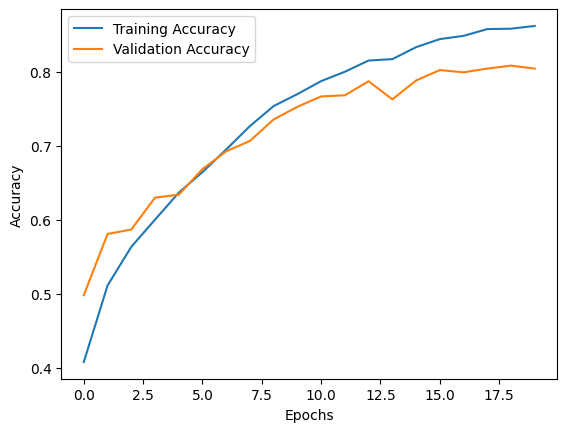

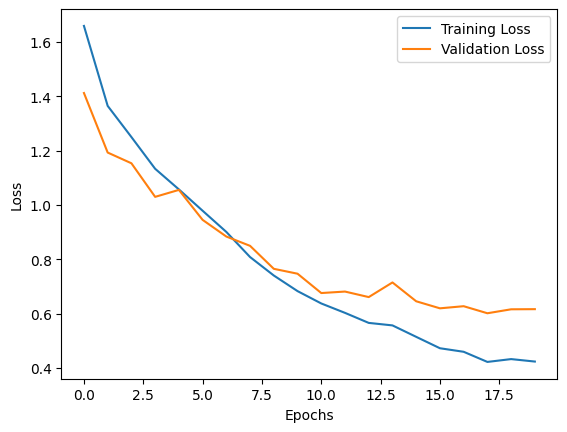

In [39]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [16]:
import numpy as np
y_pred = model.predict(X_test)
# Convert y_pred from probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)


63/63 [==============================] - 3s 42ms/step


In [35]:
# Convert adjusted labels back to their original format (if needed)
y_test_original = y_test_adjusted + 1



In [37]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test_adjusted, y_pred_labels, target_names=genres)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

       blues       0.84      0.82      0.83       209
   classical       0.90      0.97      0.93       203
     country       0.70      0.72      0.71       189
       disco       0.84      0.69      0.76       191
      hiphop       0.77      0.83      0.80       214
        jazz       0.79      0.79      0.79       183
       metal       0.87      0.91      0.89       197
         pop       0.87      0.89      0.88       198
      reggae       0.84      0.82      0.83       207
        rock       0.68      0.66      0.67       207

    accuracy                           0.81      1998
   macro avg       0.81      0.81      0.81      1998
weighted avg       0.81      0.81      0.81      1998



In [19]:
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical if not already done
y_categorical = to_categorical(y_adjusted)

# Check the number of classes in the output layer
num_classes = y_categorical.shape[1]
print("Number of classes:", num_classes)


Number of classes: 10


In [20]:
min_label = np.min(y)
max_label = np.max(y)
print("Minimum label:", min_label)
print("Maximum label:", max_label)


Minimum label: 1
Maximum label: 10


In [21]:
y_test_original = y_test_adjusted - 1


**MANUAL GRID SEARCH TO FIND BEST PARAMETERS:**

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import numpy as np

# Load your data (X and y) here
#   'X' contains your features and 'y' contains your original labels

# Define hyperparameters to be tested
units_list = [64, 128]
dropout_list = [0.2, 0.3]
batch_size_list = [32, 64]
epochs_list = [10, 20]

best_accuracy = 0
best_params = {}

# Iterate through each combination of hyperparameters
for units in units_list:
    for dropout in dropout_list:
        for batch_size in batch_size_list:
            for epochs in epochs_list:
                # Create the LSTM model
                model = Sequential([
                    LSTM(units=units, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
                    Dropout(dropout),
                    LSTM(units=int(units / 2)),
                    Dropout(dropout),
                    Dense(len(np.unique(y)), activation='softmax')
                ])

                # Compile the model
                model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

                # Adjust labels for training purposes
                y_adjusted_train = y - 1  # Adjusting labels for training

                # Split the data into training and testing sets
                X_train, X_test, y_train_adjusted, y_test = train_test_split(X, y_adjusted_train, test_size=0.2, random_state=42)

                # Train the model
                model.fit(X_train, y_train_adjusted, epochs=epochs, batch_size=batch_size, verbose=0)

                # Evaluate the model
                test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

                # Save the best parameters and accuracy
                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_params = {
                        'units': units,
                        'dropout': dropout,
                        'batch_size': batch_size,
                        'epochs': epochs
                    }

print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)
 


Best Accuracy: 0.8313313126564026
Best Parameters: {'units': 128, 'dropout': 0.3, 'batch_size': 32, 'epochs': 20}


In [16]:
best_params = {'units': 128, 'dropout': 0.3, 'batch_size': 32, 'epochs': 20}

In [17]:
# Creating the LSTM model using the best hyperparameters
final_model = Sequential([
    LSTM(units=best_params['units'], input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(best_params['dropout']),
    LSTM(units=int(best_params['units'] / 2)),
    Dropout(best_params['dropout']),
    Dense(len(np.unique(y)), activation='softmax')
])

# Compiling the model
final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the final model using the entire dataset
final_model.fit(X, y_adjusted, epochs=best_params['epochs'], batch_size=best_params['batch_size'])


Epoch 1/20
313/313 [==============================] - 59s 174ms/step - loss: 1.5212 - accuracy: 0.4593
Epoch 2/20
313/313 [==============================] - 54s 173ms/step - loss: 1.2255 - accuracy: 0.5691
Epoch 3/20
313/313 [==============================] - 54s 173ms/step - loss: 1.0873 - accuracy: 0.6228
Epoch 4/20
313/313 [==============================] - 55s 175ms/step - loss: 1.0098 - accuracy: 0.6541
Epoch 5/20
313/313 [==============================] - 55s 176ms/step - loss: 0.8933 - accuracy: 0.6967
Epoch 6/20
313/313 [==============================] - 54s 173ms/step - loss: 0.8299 - accuracy: 0.7167
Epoch 7/20
313/313 [==============================] - 55s 176ms/step - loss: 0.7445 - accuracy: 0.7536
Epoch 8/20
313/313 [==============================] - 55s 175ms/step - loss: 0.6842 - accuracy: 0.7716
Epoch 9/20
313/313 [==============================] - 54s 174ms/step - loss: 0.6579 - accuracy: 0.7859
Epoch 10/20
313/313 [==============================] - 54s 174ms/step - l

In [18]:
final_model.evaluate(X_test)

63/63 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [19]:
y_test_final = final_model.predict(X_test)
y_pred_final_labels = np.argmax(y_test_final, axis=1)
# Generate the classification report
report_lstm_final = classification_report(y_test_adjusted, y_pred_final_labels, target_names=genres)
print("Classification Report for LSTM best model:\n", report_lstm_final)

63/63 [==============================] - 4s 52ms/step
Classification Report for LSTM best model:
               precision    recall  f1-score   support

       blues       0.98      0.86      0.91       209
   classical       0.94      0.99      0.97       203
     country       0.80      0.92      0.86       189
       disco       0.83      0.93      0.88       191
      hiphop       0.96      0.87      0.92       214
        jazz       0.92      0.90      0.91       183
       metal       0.90      0.96      0.93       197
         pop       0.92      0.93      0.93       198
      reggae       0.93      0.94      0.93       207
        rock       0.92      0.79      0.85       207

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998



In [28]:
# Evaluating the final model
test_loss, test_accuracy = final_model.evaluate(X_test, y_test_adjusted)
print(f"Test accuracy of the final model: {test_accuracy:.4f}")


63/63 [==============================] - 3s 46ms/step - loss: 0.2336 - accuracy: 0.9204
Test accuracy of the final model: 0.9204


**TRAINING THE GRU MODEL**

In [27]:
#training the GRU model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Create the GRU model
model_gru = Sequential([
    GRU(units=128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(0.3),  # Adding dropout for regularization
    GRU(units=64),
    Dropout(0.3),
    Dense(len(genres), activation='softmax')
])

# Compile the GRU model
model_gru.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train the GRU model
model_train_gru = model_gru.fit(X_train, y_train_adjusted, epochs=20, batch_size=32, validation_data=(X_test, y_test_adjusted))

# Evaluate the GRU model
test_loss_gru, test_acc_gru = model_gru.evaluate(X_test, y_test_adjusted)
print(f"Test accuracy using GRU: {test_acc_gru:.4f}")


Epoch 1/20
250/250 [==============================] - 50s 111ms/step - loss: 1.6269 - accuracy: 0.4191 - val_loss: 1.1883 - val_accuracy: 0.5696
Epoch 2/20
250/250 [==============================] - 6930s 28s/step - loss: 1.1567 - accuracy: 0.5924 - val_loss: 0.9490 - val_accuracy: 0.6612
Epoch 3/20
250/250 [==============================] - 28s 113ms/step - loss: 0.9500 - accuracy: 0.6731 - val_loss: 0.8257 - val_accuracy: 0.7057
Epoch 4/20
250/250 [==============================] - 29s 118ms/step - loss: 0.8082 - accuracy: 0.7256 - val_loss: 0.8202 - val_accuracy: 0.7172
Epoch 5/20
250/250 [==============================] - 34s 137ms/step - loss: 0.7119 - accuracy: 0.7566 - val_loss: 0.7180 - val_accuracy: 0.7457
Epoch 6/20
250/250 [==============================] - 29s 117ms/step - loss: 0.6157 - accuracy: 0.7934 - val_loss: 0.6570 - val_accuracy: 0.7808
Epoch 7/20
250/250 [==============================] - 32s 127ms/step - loss: 0.5534 - accuracy: 0.8130 - val_loss: 0.6314 - val_ac

**MANUAL GRID SEARCH FOR THE GRU MODEL:**

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import numpy as np

# Define the hyperparameters to be tested
units_list = [64, 128]
dropout_list = [0.2, 0.3]
batch_size_list = [32, 64]
epochs_list = [10, 20]

best_accuracy = 0
best_params = {}

# Iterate through each combination of hyperparameters
for units in units_list:
    for dropout_rate in dropout_list:
        for batch_size in batch_size_list:
            for epochs in epochs_list:
                # Create the GRU model
                model = Sequential([
                    GRU(units=units, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
                    Dropout(dropout_rate),
                    GRU(units=int(units / 2)),
                    Dropout(dropout_rate),
                    Dense(len(np.unique(y)), activation='softmax')
                ])

                # Compile the model
                model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

                # Train the model
                model.fit(X_train, y_train_adjusted, epochs=epochs, batch_size=batch_size, verbose=0)

                # Evaluate the model
                _, test_accuracy = model.evaluate(X_test, y_test_adjusted, verbose=0)

                # Save the best parameters and accuracy
                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_params = {
                        'units': units,
                        'dropout_rate': dropout_rate,
                        'batch_size': batch_size,
                        'epochs': epochs
                    }

print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)


Best Accuracy: 0.8453453183174133
Best Parameters: {'units': 128, 'dropout_rate': 0.2, 'batch_size': 32, 'epochs': 20}


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_rnn, y_adjusted, test_size=0.2, random_state=42)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)  # Reshape validation data if needed

# Create the GRU model with the best parameters
best_units = 128
best_dropout_rate = 0.2
best_batch_size = 32
best_epochs = 20

gru_model = Sequential([
    GRU(units=best_units, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(best_dropout_rate),
    GRU(units=int(best_units / 2)),
    Dropout(best_dropout_rate),
    Dense(len(np.unique(y)), activation='softmax')
])

# Compile the model
gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with the training data and validate on validation data
history = gru_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size,
                        validation_data=(X_val, y_val))

# Use the trained model to make predictions on the test set
y_pred_gru = gru_model.predict(X_test_reshaped)
y_pred_labels_gru = np.argmax(y_pred_gru, axis=1)




Epoch 1/20
250/250 [==============================] - 44s 159ms/step - loss: 1.5427 - accuracy: 0.4420 - val_loss: 1.1819 - val_accuracy: 0.5741
Epoch 2/20
250/250 [==============================] - 38s 154ms/step - loss: 1.0942 - accuracy: 0.6127 - val_loss: 0.9664 - val_accuracy: 0.6567
Epoch 3/20
250/250 [==============================] - 40s 160ms/step - loss: 0.9102 - accuracy: 0.6862 - val_loss: 0.8771 - val_accuracy: 0.6917
Epoch 4/20
250/250 [==============================] - 38s 153ms/step - loss: 0.7838 - accuracy: 0.7316 - val_loss: 0.7630 - val_accuracy: 0.7327
Epoch 5/20
250/250 [==============================] - 38s 153ms/step - loss: 0.6783 - accuracy: 0.7679 - val_loss: 0.7672 - val_accuracy: 0.7397
Epoch 6/20
250/250 [==============================] - 44s 175ms/step - loss: 0.6088 - accuracy: 0.7922 - val_loss: 0.6605 - val_accuracy: 0.7778
Epoch 7/20
250/250 [==============================] - 43s 173ms/step - loss: 0.5458 - accuracy: 0.8130 - val_loss: 0.7044 - val_ac

NameError: name 'X_test_reshaped' is not defined

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import classification_report

# Create the GRU model with the best parameters
best_units = 128
best_dropout_rate = 0.2
best_batch_size = 32
best_epochs = 20

gru_model = Sequential([
    GRU(units=best_units, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(best_dropout_rate),
    GRU(units=int(best_units / 2)),
    Dropout(best_dropout_rate),
    Dense(len(np.unique(y)), activation='softmax')
])

# Compile the model
gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with the entire dataset
history = gru_model.fit(X_rnn, y_adjusted, epochs=best_epochs, batch_size=best_batch_size)

# Use the trained model to make predictions
y_pred = gru_model.predict(X_test_reshaped)
y_pred_labels = np.argmax(y_pred, axis=1)



Epoch 1/20
313/313 [==============================] - 50s 144ms/step - loss: 1.4989 - accuracy: 0.4573
Epoch 2/20
313/313 [==============================] - 45s 144ms/step - loss: 1.0449 - accuracy: 0.6294
Epoch 3/20
313/313 [==============================] - 45s 143ms/step - loss: 0.8448 - accuracy: 0.7042
Epoch 4/20
313/313 [==============================] - 45s 145ms/step - loss: 0.6970 - accuracy: 0.7555
Epoch 5/20
313/313 [==============================] - 45s 143ms/step - loss: 0.6220 - accuracy: 0.7856
Epoch 6/20
313/313 [==============================] - 45s 144ms/step - loss: 0.5449 - accuracy: 0.8165
Epoch 7/20
313/313 [==============================] - 46s 145ms/step - loss: 0.4881 - accuracy: 0.8374
Epoch 8/20
313/313 [==============================] - 45s 144ms/step - loss: 0.4469 - accuracy: 0.8476
Epoch 9/20
313/313 [==============================] - 46s 148ms/step - loss: 0.4126 - accuracy: 0.8599
Epoch 10/20
313/313 [==============================] - 45s 145ms/step - l

**CLASSIFICATION REPORT FOR BEST GRU model:**

In [ ]:
y_test_gru

In [55]:
y_test_final_gru = gru_model.predict(X_test)
y_pred_final_labels_gru = np.argmax(y_test_final_gru, axis=1)
# Generate the classification report
report_lstm_final = classification_report(y_test_adjusted, y_pred_final_labels_gru, target_names=genres)
print("Classification Report for LSTM model:\n", report_lstm_final)

63/63 [==============================] - 3s 41ms/step
Classification Report for LSTM model:
               precision    recall  f1-score   support

       blues       0.98      0.93      0.96       209
   classical       0.97      0.99      0.98       203
     country       0.92      0.94      0.93       189
       disco       0.98      0.96      0.97       191
      hiphop       1.00      0.95      0.97       214
        jazz       0.92      0.96      0.94       183
       metal       0.98      0.95      0.97       197
         pop       1.00      0.94      0.97       198
      reggae       0.94      0.99      0.96       207
        rock       0.88      0.94      0.91       207

    accuracy                           0.96      1998
   macro avg       0.96      0.96      0.96      1998
weighted avg       0.96      0.96      0.96      1998



**THE BERT MODEL:**
*Google's BERT (Bidirectional Encoder Representations from Transformers) is a strong language representation model particularly geared for natural language understanding jobs. While BERT excels at numerous NLP tasks such as text classification, entity recognition, and question answering, its direct application to audio data for tasks such as audio classification is difficult due to its nature as a text language model.*

*the focus here is on audio data processing using MFCC features and applying RNN (LSTM and GRU) models for classification. BERT, being an NLP model, might not be directly applicable for audio classification tasks.*

*For audio classification tasks, models like Convolutional Neural Networks (CNNs), Recurrent Neural Networks (RNNs), Time-Distributed CNNs with RNNs (CNN-RNN hybrids), or more advanced architectures like Transformers with attention mechanisms tailored for audio (e.g., Transformer Encoders for audio data) are more suitable.*

**Therefore inplace of the BERT model, we built a CNN model**

Epoch 1/20
250/250 [==============================] - 9s 25ms/step - loss: 2.3297 - accuracy: 0.3374 - val_loss: 1.5743 - val_accuracy: 0.4404
Epoch 2/20
250/250 [==============================] - 4s 18ms/step - loss: 1.5556 - accuracy: 0.4335 - val_loss: 1.4131 - val_accuracy: 0.4890
Epoch 3/20
250/250 [==============================] - 4s 17ms/step - loss: 1.4399 - accuracy: 0.4777 - val_loss: 1.3294 - val_accuracy: 0.5190
Epoch 4/20
250/250 [==============================] - 4s 17ms/step - loss: 1.3532 - accuracy: 0.5106 - val_loss: 1.3010 - val_accuracy: 0.5330
Epoch 5/20
250/250 [==============================] - 4s 17ms/step - loss: 1.2438 - accuracy: 0.5466 - val_loss: 1.2178 - val_accuracy: 0.5616
Epoch 6/20
250/250 [==============================] - 4s 17ms/step - loss: 1.1994 - accuracy: 0.5663 - val_loss: 1.2666 - val_accuracy: 0.5445
Epoch 7/20
250/250 [==============================] - 4s 17ms/step - loss: 1.1080 - accuracy: 0.6010 - val_loss: 1.2678 - val_accuracy: 0.5556

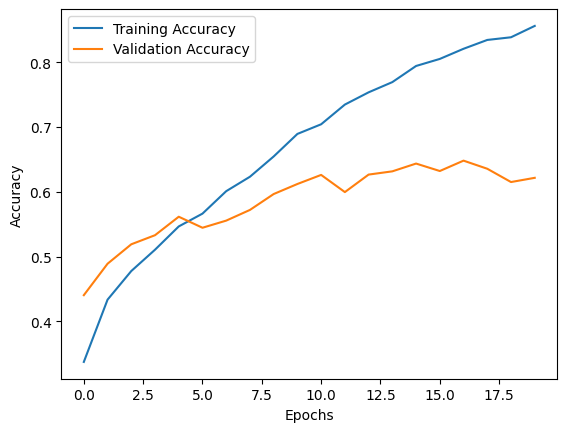

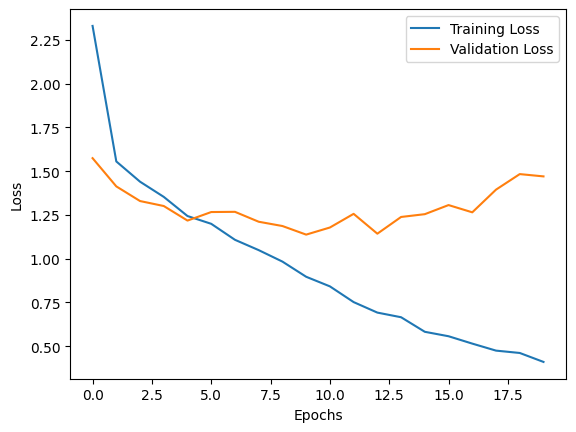

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#   X contains MFCC data and y contains labels

X_cnn = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)  # Adding a channel dimension for CNN

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y_adjusted, test_size=0.2, random_state=42)

# Create the CNN model
model_cnn = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')  # Output layer with softmax activation
])

# Compile the CNN model
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
history_cnn = model_cnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the CNN model
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(X_test, y_test)
print(f"Test accuracy using CNN: {test_acc_cnn:.4f}")

# Plot training and validation accuracy
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
from sklearn.model_selection import train_test_split

#  X contains MFCC data and y contains labels

X_cnn = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)  # Adding a channel dimension for CNN

# Define hyperparameters to be tested
filters_list = [32, 64]
kernel_sizes = [(3, 3), (4, 4)]
dense_units = [64, 128]
dropout_rates = [0.3, 0.5]

best_accuracy = 0
best_params = {}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y_adjusted, test_size=0.2, random_state=42)

# Iterate through each combination of hyperparameters
for filters in filters_list:
    for kernel_size in kernel_sizes:
        for dense_unit in dense_units:
            for dropout_rate in dropout_rates:
                # Create the CNN model
                model = Sequential([
                    Conv2D(filters, kernel_size=kernel_size, activation='relu', input_shape=(X.shape[1], X.shape[2], 1)),
                    MaxPooling2D(pool_size=(2, 2)),
                    Flatten(),
                    Dense(dense_unit, activation='relu'),
                    Dropout(dropout_rate),
                    Dense(len(np.unique(y)), activation='softmax')  # Output layer with softmax activation
                ])

                # Compile the CNN model
                model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

                # Train the CNN model
                history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

                # Evaluate the CNN model
                _, test_accuracy = model.evaluate(X_test, y_test)

                # Save the best parameters and accuracy
                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_params = {
                        'filters': filters,
                        'kernel_size': kernel_size,
                        'dense_units': dense_unit,
                        'dropout_rate': dropout_rate
                    }

print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)


63/63 [==============================] - 1s 15ms/step - loss: 2.3031 - accuracy: 0.0946
Best Accuracy: 0.35035035014152527
Best Parameters: {'filters': 32, 'kernel_size': (4, 4), 'dense_units': 128, 'dropout_rate': 0.3}


In [68]:
gru_model.save('gru_model.h5')

C:\Users\ayoba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [69]:
import json

# Load data from the JSON file generated by save_mfcc function
with open(json_path, 'r') as f:
    data = json.load(f)

# Extract the genres and their corresponding semantic labels
genres = data['mapping']

# Display the mapping of genres
for idx, genre in enumerate(genres):
    print(f"Label: {idx}, Genre: {genre}")


Label: 0, Genre: blues
Label: 1, Genre: classical
Label: 2, Genre: country
Label: 3, Genre: disco
Label: 4, Genre: hiphop
Label: 5, Genre: jazz
Label: 6, Genre: metal
Label: 7, Genre: pop
Label: 8, Genre: reggae
Label: 9, Genre: rock


In [31]:
# Load a new audio file and extract MFCCs
new_audio_file = r"C:\Users\ayoba\OneDrive - Ashesi University\Year 2 sem 2 fall\AI\FINAL PROJECT\Data\genres_original\hiphop\hiphop.00027.wav"
signal, sr = librosa.load(new_audio_file, sr=SAMPLE_RATE, duration=30)  # Load only the first 30 seconds

# Extract MFCCs from the loaded audio file
mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)
mfccs = mfccs.T  # Transpose the matrix to match the shape used for training

# Reshape the MFCCs to match the input shape of the model
mfccs_reshaped = mfccs.reshape(1, mfccs.shape[0], mfccs.shape[1])  # 3D tensor (1, time_steps, num_features)

# Make predictions
predictions = final_model.predict(mfccs_reshaped)

# Convert predictions to class labels
predicted_label = np.argmax(predictions, axis=1)[0]  #  single prediction
predicted_genre = genres[predicted_label] 

print(f"Predicted Genre: {predicted_genre}")

1/1 [==============================] - 0s 297ms/step
Predicted Genre: hiphop


In [28]:
input_shape = final_model.input_shape
print("Input shape of the model:", input_shape)


Input shape of the model: (None, 130, 13)


In [24]:
# Load a new audio file and extract MFCCs
new_audio_file = r"C:\Users\ayoba\Downloads\Eminem_-_Mockingbird_[NaijaGreen.Com]_.mp3"
signal, sr = librosa.load(new_audio_file, sr=SAMPLE_RATE, duration=30)  # Load only the first 30 seconds

# Extract MFCCs from the loaded audio file
mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)
mfccs = mfccs.T  # Transpose the matrix to match the shape used for training

# Reshape the MFCCs to match the input shape of the model
mfccs_reshaped = mfccs.reshape(1, mfccs.shape[0], mfccs.shape[1])  # 3D tensor (1, time_steps, num_features)

# Make predictions
predictions = final_model.predict(mfccs_reshaped)

# Convert predictions to class labels
predicted_label = np.argmax(predictions, axis=1)[0]  #   single prediction
predicted_genre = genres[predicted_label]  #   'genres' is the list of class names

print(f"Predicted Genre: {predicted_genre}")

1/1 [==============================] - 0s 253ms/step
Predicted Genre: hiphop
